In [565]:
import pandas as pd
import pickle
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from itertools import chain
from collections import Counter, OrderedDict, defaultdict
from pprint import pprint
import re

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import RandomizedSearchCV
from sklearn.cluster import KMeans

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

from keras.preprocessing.text import one_hot, text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences

from tqdm import tqdm

import numpy as np
import itertools
import unicodedata

import joblib
import pickle

# Helpers

In [2]:
def char_ngrams(word, start=2, end=4):
    try:
        assert end > start
    except AssertionError:
        print('Start should be greater that end!')
    
    n_grams = []
    for i in range(start, end + 1):
        for j in range(len(word) - i + 1):
            n_grams.append(word[j:j + i])
    if len(n_grams) == 0:
        n_grams = [word]
    return n_grams

In [3]:
def char_embeddings(ngrams):
    chars = [' '.join(ngrams)]
    vocab_size = 100
    encoded_chars = [one_hot(c, vocab_size) for c in chars]
    max_length = 50
    padded_chars = pad_sequences(encoded_chars, maxlen=max_length, padding='post')
    return padded_chars[0].tobytes()

In [482]:
def word2features(sent, i):
    word = unicodedata.normalize("NFKD", sent[i])
    word = word.strip(' .!?",:-;%#*“”«»\t\n')
    
    features = {
        'word.lower()': word.lower(),
        'len(word)': len(word),
        #'word[-3:]': word[-3:],
        #'word[-2:]': word[-2:],
        'word n-grams': char_ngrams(word.lower(), 1, 3)
        #'word char embeddings': char_embeddings(list(''.join(char_ngrams(word))))
    }
    
    if i > 1:
        word1 = unicodedata.normalize("NFKD", sent[i-1])
        word1 = word1.strip(' .!?",:-;%#*“”«»\t\n')
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word n-grams': char_ngrams(word1.lower(), 1, 3)
            #'-1:word char embeddings': char_embeddings(list(''.join(char_ngrams(word1))))
        })
    else:
        features['BOS'] = True
        
    
        
    if i < len(sent)-2:
        word1 = unicodedata.normalize("NFKD", sent[i+1])
        word1 = word1.strip(' .!?",:-;%#*“”«»\t\n')
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word n-grams': char_ngrams(word1.lower(), 1, 3)
            #'+1:word char embeddings': char_embeddings(list(''.join(char_ngrams(word1))))
        })
    else:
        features['EOS'] = True
    return features

In [5]:
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

In [6]:
def predict_language(crf, test_sent):
    test_features = sent2features(test_sent.split(' '))
    X_sent = []
    for i in range(len(test_features)):
        X_sent.append([test_features[i]])
    preds = crf.predict(X_sent)
    tokens = test_sent.split(' ')
    sentence = []
    for i in range(len(preds)):
        sentence.append((tokens[i], preds[i][0]))
    return sentence

In [474]:
MODEL_FILE = 'crf_lang_detect_ngrams_no_wiki_2window.pkl'
LANG_DATA_FILE = 'lang_data_no_wiki.pkl2'

# Обучение классификатора

In [21]:
langs = {'ru': 0, 'tt': 1, 'ba': 2, 'sah': 3, 'udm': 4}
id_to_lang = {v: k for k, v in langs.items()}

In [117]:
texts = pickle.load(open(LANG_DATA_FILE, 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: 'lang_data_no_wiki.pkl2'

In [483]:
data = {'lang': [], 'text': []}
for lang in langs.keys():
    raw_texts = open('LSTM/LSTM/{}.txt'.format(lang), encoding='utf-8').read().split('\n')
    for text in raw_texts:
        if len(text) > 50 and len(text) < 200:
            data['lang'].append(lang)
            data['text'].append(text)
        elif len(text) > 50:
            data['lang'].append(lang)
            data['text'].append(' '.join(text[:200].split()[:-1]))
texts = pd.DataFrame(data=data)

In [484]:
from sklearn.utils import shuffle
new_texts = pd.concat([shuffle(texts.query('lang == "{}"'.format(lang)))[:7500] for lang in ['ru', 'tt', 'ba', 'udm', 'sah']])
new_texts = new_texts.sample(frac=1).reset_index(drop=True)
print(len(new_texts.text))

37500


In [485]:
texts.lang[10000]

'ru'

In [486]:
sent2features(new_texts.text[0].split(' '))
X_all = [sent2features(s.split(' ')) for s in tqdm(new_texts.text)]

100%|███████████████████████████████████████████████████████████████████████████| 37500/37500 [00:47<00:00, 797.37it/s]


In [487]:
y_all = [label for label in new_texts.lang]
y_all[1000]

'tt'

In [488]:
X = []
y = []
for i in range(len(X_all)):
    for f in range(len(X_all[i])):
        X.append([X_all[i][f]])
        y.append([y_all[i]])

In [168]:
from sklearn.model_selection import train_test_split
?train_test_split

In [489]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [490]:
X_train[4], y_train[4]

([{'+1:word n-grams': ['ч', 'т', 'о', 'чт', 'то', 'что'],
   '+1:word.lower()': 'что',
   '-1:word n-grams': ['а',
    'н',
    'а',
    'л',
    'и',
    'з',
    'и',
    'р',
    'о',
    'в',
    'а',
    'т',
    'ь',
    'ан',
    'на',
    'ал',
    'ли',
    'из',
    'зи',
    'ир',
    'ро',
    'ов',
    'ва',
    'ат',
    'ть',
    'ана',
    'нал',
    'али',
    'лиз',
    'изи',
    'зир',
    'иро',
    'ров',
    'ова',
    'ват',
    'ать'],
   '-1:word.lower()': 'анализировать',
   'len(word)': 2,
   'word n-grams': ['т', 'о', 'то'],
   'word.lower()': 'то'}],
 ['ru'])

In [491]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

Wall time: 5min 6s


In [492]:
labels = list(crf.classes_)
labels

['tt', 'udm', 'ru', 'sah', 'ba']

In [493]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred,
                      average='weighted', labels=labels)

0.9688631467411942

In [494]:
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

             precision    recall  f1-score   support

         ba      0.943     0.929     0.936     31578
        sah      0.996     0.998     0.997     36540
        udm      0.987     0.979     0.983     31773
         tt      0.938     0.944     0.941     36432
         ru      0.977     0.988     0.982     41719

avg / total      0.969     0.969     0.969    178042



In [495]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[29336   253    61  1833    95]
 [  148 41222     4   202   143]
 [   19     6 36452    60     3]
 [ 1512   324    55 34386   155]
 [   93   389    14   168 31109]]
Normalized confusion matrix
[[9.29e-01 8.01e-03 1.93e-03 5.80e-02 3.01e-03]
 [3.55e-03 9.88e-01 9.59e-05 4.84e-03 3.43e-03]
 [5.20e-04 1.64e-04 9.98e-01 1.64e-03 8.21e-05]
 [4.15e-02 8.89e-03 1.51e-03 9.44e-01 4.25e-03]
 [2.93e-03 1.22e-02 4.41e-04 5.29e-03 9.79e-01]]


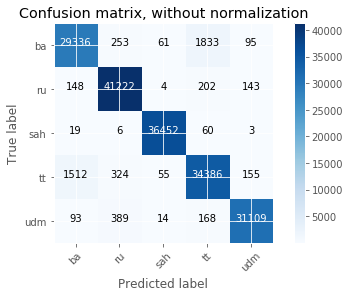

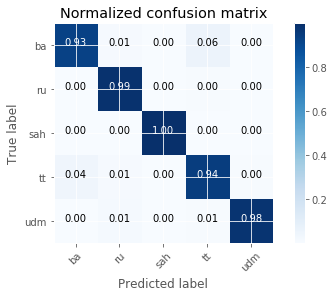

In [496]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

classes = ['ba', 'ru', 'sah', 'tt', 'udm']

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

plt.savefig('confusion.png')
plt.show()

In [497]:
test_sent_ba = "Өфө миллионлы ҡалалар араһында төшкө аштың арзанлығы буйынса 10-сы урынды биләй. Рейтингты «2ГИС» сервисы төҙөгән. Аналитиктар һөҙөмтәләрҙе 2015 йылғы хаҡтар менән сағыштырып, бизнес-ланчтың ниндәй ҡалала ҡиммәтләнеүен һәм арзанайыуын асыҡлаған."
test_sent = "чыгу тырышу кирәк бу шөгыль гомер буена сузылырга тиеш необходимо пытаться превосходить самого себя постоянно и это занятие должно длиться всю жизнь"

In [498]:
predict_language(crf, test_sent_ba)

[('Өфө', 'ba'),
 ('миллионлы', 'ba'),
 ('ҡалалар', 'ba'),
 ('араһында', 'ba'),
 ('төшкө', 'ba'),
 ('аштың', 'ba'),
 ('арзанлығы', 'ba'),
 ('буйынса', 'ba'),
 ('10-сы', 'ba'),
 ('урынды', 'ba'),
 ('биләй.', 'ba'),
 ('Рейтингты', 'ba'),
 ('«2ГИС»', 'ba'),
 ('сервисы', 'ba'),
 ('төҙөгән.', 'ba'),
 ('Аналитиктар', 'ba'),
 ('һөҙөмтәләрҙе', 'ba'),
 ('2015', 'ba'),
 ('йылғы', 'ba'),
 ('хаҡтар', 'ba'),
 ('менән', 'ba'),
 ('сағыштырып,', 'ba'),
 ('бизнес-ланчтың', 'ba'),
 ('ниндәй', 'ba'),
 ('ҡалала', 'ba'),
 ('ҡиммәтләнеүен', 'ba'),
 ('һәм', 'ba'),
 ('арзанайыуын', 'ba'),
 ('асыҡлаған.', 'ba')]

In [499]:
from collections import Counter

def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
6.326580 ba       -1:word n-grams:ҡ
5.905312 ba       +1:word.lower():ла
5.865494 ba       word.lower():ла
5.786171 ba       -1:word.lower():ла
5.623955 ba       word.lower():улар
5.583409 ba       -1:word.lower():улар
5.413887 ba       word n-grams:ҡ
5.224471 ba       +1:word n-grams:еү
5.125854 ba       +1:word n-grams:ҙ
5.108977 ba       word n-grams:ҙ
5.078298 ba       +1:word n-grams:ҡ
5.027207 tt       word n-grams:җ
5.016189 tt       +1:word n-grams:җ
4.980487 sah      word n-grams:ҥ
4.979963 ba       +1:word.lower():улар
4.908602 ba       word n-grams:ғ
4.823836 tt       -1:word n-grams:җ
4.793739 udm      +1:word n-grams: 
4.790903 tt       +1:word.lower():бу
4.790149 ba       +1:word n-grams:ғ
4.733546 udm      word.lower():арын
4.705163 ba       -1:word n-grams:ҙ
4.677601 sah      word n-grams:ҕ
4.601889 ba       +1:word.lower():лә
4.540159 udm      -1:word n-grams:ысь
4.516618 ru       word.lower():в
4.493140 ba       -1:word n-grams:ғ
4.485810 ba       word.l

In [500]:
joblib.dump(crf, MODEL_FILE)

['crf_lang_detect_ngrams_no_wiki_2window.pkl']

# Загрузка классификатора

In [544]:
MODEL_FILE = 'crf_lang_detect_ngrams_no_wiki_2window.pkl'
crf = joblib.load(MODEL_FILE)

In [13]:
?np.argmax

In [545]:
def most_common(lst):
    return max(set(lst), key=lst.count)
y_test = []
y_pred = []
test_sents = open('test_comments.txt', encoding='utf-8').read().split('\n')
for sent in test_sents:
    sent = sent.split()
    y_test.append(sent[0])
    test_sent = ' '.join(sent[1:])
    preds = predict_language(crf, test_sent)
    lang_preds = [pred[1] for pred in preds]
    y_pred.append(most_common(lang_preds))

In [546]:
fasttext_test = open('test_comments_fasttext.txt', encoding='utf-8').read().split('\n')
y_test_ft = [label.split()[0].replace('__label__', '') for label in fasttext_test]
fasttext_preds = open('fasttext_test_results.txt', encoding='utf-8').read().split('\n')
y_pred_ft = [label.replace('__label__', '') for label in fasttext_preds]

In [547]:
cs_test = open('cs_test.txt', encoding='utf-8').read().split('\n')
X_test_cs = []
y_test_cs = []
for test in cs_test:
    y_test_cs.extend([token.split('_')[1] for token in test.split()])
    X_test_cs.append(' '.join([token.split('_')[0] for token in test.split()]))
y_pred_cs = []
for test in X_test_cs:
    y_pred_cs.extend([pred[1] for pred in predict_language(crf, test)])

In [548]:
print('\t\tCRF language identifier')
sorted_labels = sorted(
    list(set(y_test)),
    key=lambda name: (name[1:], name[0])
)
print(sklearn.metrics.classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

		CRF language identifier
             precision    recall  f1-score   support

         ba      0.976     0.800     0.879        50
        sah      1.000     1.000     1.000        50
         tt      0.831     0.980     0.899        50
         ru      1.000     1.000     1.000        50

avg / total      0.952     0.945     0.945       200



In [542]:
print('\t\tFastText language identifier')
sorted_labels_ft = sorted(
    list(set(y_test_ft)),
    key=lambda name: (name[1:], name[0])
)
print(sklearn.metrics.classification_report(
    y_test_ft, y_pred_ft, labels=sorted_labels_ft, digits=3
))

		FastText language identifier
             precision    recall  f1-score   support

         ba      0.958     0.460     0.622        50
        sah      0.877     1.000     0.935        50
         tt      0.696     0.780     0.736        50
         ru      0.877     1.000     0.935        50

avg / total      0.852     0.810     0.807       200



In [536]:
print('\t\tCRF language identifier on code-switching data')
sorted_labels_cs = sorted(
    list(set(y_test_cs)),
    key=lambda name: (name[1:], name[0])
)
print(sklearn.metrics.classification_report(
    y_test_cs, y_pred_cs, labels=sorted_labels_cs, digits=3
))

		CRF language identifier on code-switching data


c:\users\milik\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

         ba      0.000     0.000     0.000        98
        sah      0.000     0.000     0.000       101
        udm      0.000     0.000     0.000        83
         tt      0.340     0.950     0.501       119
         ru      0.751     0.921     0.827       304

avg / total      0.381     0.557     0.441       705



In [631]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt=".2f", annot_kws={"size": 20})
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)
    return fig

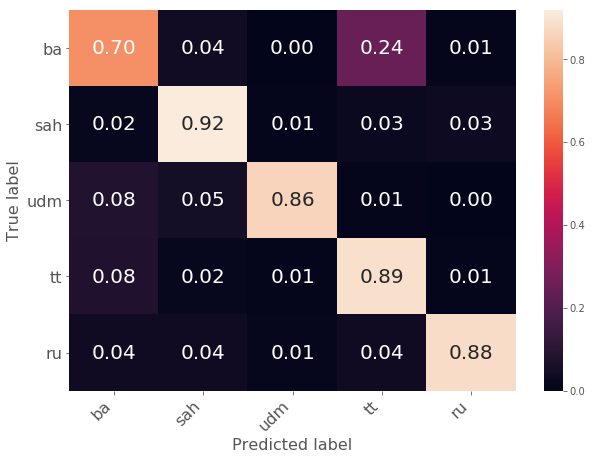

In [632]:
cnf_matrix_cs = confusion_matrix(y_test_cs, y_pred_cs)
np.set_printoptions(precision=2)

classes = ['ba', 'ru', 'sah', 'tt', 'udm']
# Plot normalized confusion matrix
print_confusion_matrix(cnf_matrix_cs, class_names=sorted_labels_cs, fontsize=16)
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

# Обработка корпуса

In [638]:
stats = Counter()
contexts_1 = {
    'ba': [],
    'tt': [],
    'udm': [],
    'sah': []
}
contexts_3 = {
    'ba': [],
    'tt': [],
    'udm': [],
    'sah': []
}

contexts_5 = {
    'ba': [],
    'tt': [],
    'udm': [],
    'sah': []
}

mixed = {
    'ba': [],
    'tt': [],
    'udm': [],
    'sah': []
}

for lang in 'ba tt udm sah'.split():
    print('Working on {}...'.format(lang))
    filename = 'vk_comments/{}_comments_tokenized_10more.txt'.format(lang)
    comments = open(filename, encoding='utf-8').read().split('\n')
    print('Total {} comments:'.format(lang), len(comments))
    comments = list(set([comment for comment in comments if len(comment) > 50 and len(comment) < 141]))
    print('Twitter-sized {} comments:'.format(lang), len(comments))
    for comment in comments:
        preds = predict_language(crf, comment)
        #for pred in predict_language(crf, comment):
        #    if pred[1] not in ['ru', lang]:
        #        preds.append((pred[0], lang))
        #    else:
        #        preds.append(pred)
        #print(preds)
        lang_preds = [pred[1] for pred in preds]
        codes = list(set([pred for pred in lang_preds if lang_preds.count(pred) > 4]))
        #print(codes, comment)
        if len(codes) == 1:
            stats[codes[0]] += 1
        elif len(codes) > 2:
            stats['ambiguous'] += 1
        else:
            for i in range(len(preds)):
                if i > 2 and preds[i][1] == 'ru':
                    if [preds[i - 3][1], preds[i - 2][1], preds[i - 1][1]] == [lang, lang, lang]:
                        contexts_1[lang].append(preds[i - 1][0])
                        contexts_3[lang].append(' '.join([preds[i - 3][0], preds[i - 2][0], preds[i - 1][0]]))
                        #contexts_5[lang].append(' '.join([preds[i - 5][0], preds[i - 4][0], preds[i - 3][0], preds[i - 2][0], preds[i - 1][0]]))
                        if comment not in mixed[lang]:
                            stats['mixed'] += 1
                            mixed[lang].append(comment)
                elif i < len(preds) - 3 and preds[i][1] == 'ru':
                    if [preds[i + 3][1], preds[i + 2][1], preds[i + 1][1]] == [lang, lang, lang]:
                        contexts_1[lang].append(preds[i + 1][0])
                        contexts_3[lang].append(' '.join([preds[i + 1][0], preds[i + 2][0], preds[i + 3][0]]))
                        #contexts_5[lang].append(' '.join([preds[i + 1][0], preds[i + 2][0], preds[i + 3][0], preds[i + 4][0], preds[i + 5][0]]))
                        if comment not in mixed[lang]:
                            stats['mixed'] += 1
                            mixed[lang].append(comment)
                #else:
                    #stats['ambiguous'] += 1
    pprint(stats)
    total_count = sum([v for k, v in stats.items() if k in ['ru', 'mixed', lang]])
    pprint([(k, (v / total_count)) for k, v in stats.items() if k in ['ru', 'mixed', lang]])
    pickle.dump(stats, open('{}_stats_new.pkl'.format(lang), 'wb'))
    stats = Counter()

Working on ba...
Total ba comments: 241137
Twitter-sized ba comments: 127494
Counter({'ba': 66453,
         'ru': 22700,
         'tt': 7394,
         'mixed': 4738,
         'ambiguous': 931,
         'sah': 7,
         'udm': 1})
[('ba', 0.7077675176534493),
 ('ru', 0.24176971168695616),
 ('mixed', 0.05046277065959463)]
Working on tt...
Total tt comments: 83656
Twitter-sized tt comments: 48676
Counter({'tt': 34561,
         'ru': 10397,
         'mixed': 1834,
         'ba': 168,
         'ambiguous': 38,
         'sah': 7,
         'udm': 2})
[('tt', 0.7386091639596513),
 ('ru', 0.2221961018977603),
 ('mixed', 0.03919473414258848)]
Working on udm...
Total udm comments: 22102
Twitter-sized udm comments: 9600
Counter({'udm': 7625,
         'ru': 1153,
         'mixed': 569,
         'sah': 13,
         'tt': 6,
         'ambiguous': 4,
         'ba': 3})
[('udm', 0.8157697657002246),
 ('mixed', 0.06087514710602332),
 ('ru', 0.123355087193752)]
Working on sah...
Total sah comments: 232

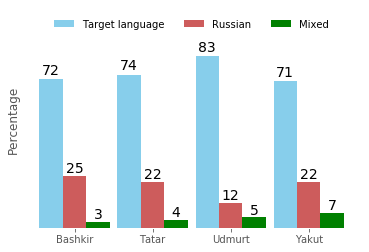

<Figure size 1440x720 with 0 Axes>

In [619]:
tgt_percent = (72, 74, 83, 71)
ru_percent = (25, 22, 12, 22)
mixed_percent = (3, 4, 5, 7)

ind = np.arange(len(tgt_percent))  # the x locations for the groups
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width, tgt_percent, width,
                color='SkyBlue', label='Target language')
rects2 = ax.bar(ind, ru_percent, width,
                color='IndianRed', label='Russian')
rects3 = ax.bar(ind + width, mixed_percent, width,
                color='Green', label='Mixed')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
#ax.set_title('Languages of the comments (≥ 3 tokens for code-switch detection)')
ax.set_yticks([])
ax.set_xticks(ind)
ax.set_xticklabels(('Bashkir', 'Tatar', 'Udmurt', 'Yakut'))
ax.set_facecolor('white')
ax.legend(loc='upper center', fancybox=True, framealpha=0, ncol=3)
ax.set_ylim(0, 105)


def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off

    for rect in rects:
        height = rect.get_height()
        ax.grid(False)
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,
                '{}'.format(height), ha=ha[xpos], va='bottom', fontsize=14)


autolabel(rects1, "center")
autolabel(rects2, "center")
autolabel(rects3, "center")

plt.savefig('cs_bar_3more.png', dpi=300)
plt.figure(figsize=(20,10))
plt.show()

In [371]:
for lang in 'ba tt udm sah'.split():
    print(mixed[lang][:50])

['а я осторожно-осторожно между каплями тиган булды инде уларга ямгыр яумаймы алля', 'мин бер кемгә лә теймәнем кемгәлер төбәп яҙманым автор молодец и я его поддерживаю уны мин уйлап сығармаған ысынында ла шулай', 'минен уйым буйынса кешелар ерза ята а эт как обычно тора', 'иң дороҫо года и в садик сразу мин оло шулай иттем икенсе кыҙыма алты ай еще йыл имә', 'иң дороҫо года и в садик сразу мин оло шулай иттем икенсе кыҙыма алты ай еще йыл имә', 'икенсе егет таба алмагандыр шуга инеп карайзыр инде счастливые бывшими не интересуются тип бушка эйтмэйзэрзер инде', 'сәләм серҙәштәр минен ошолай була почему девушки боятся смотреть в глаза арнала был', 'сәләм серҙәштәр минен ошолай була почему девушки боятся смотреть в глаза арнала был', 'мне короче нечего сказать тупой тупой инде оят тигән нәмәң юҡ икән былай', 'как бы егетен мн мирись или как бы егетендан как бы тигане ла калмас', 'как бы егетен мн мирись или как бы егетендан как бы тигане ла калмас', 'цитатахыз за всё понятно братка ана б

['воштон шуысал дыр не совсем корректно конечно но укул кылэз ми пал удмуртъес вообще уз валалэ', 'воштон шуысал дыр не совсем корректно конечно но укул кылэз ми пал удмуртъес вообще уз валалэ', 'ненай я такойже тока я удмурт-русский но незню удм но ежу в лагерь и тама мне всё понятно', 'да ладно шарканын ваще озьы уг верасько это по-любому влияние южных районов пичи пурга алнаш', 'начиная с февраля радио вы можете слышать в прямом эфире тулыспалысь кутскыса радио меч ак эфирын ужа', 'игорь упс адӟысал ке вунэтысал хд умею я поймать кадр хз', 'шулдыръяськонэз нуозы вечер будут вести мон я любик но чумоле олеш алексей бегешев', 'шулдыръяськонэз нуозы вечер будут вести мон я любик но чумоле олеш алексей бегешев', 'потэ ке мед мыноз утчалоз ассэ и не факт что перьме мынса удмуртлыкез вунэтоз', 'татьяна поволжья асьме таня щёткина вице-мисс луиз нырысетӥ интыын татьяна дудникова г саранск мгу им н п огарёва', 'яроз саша туж нормуль но для радости моих синъес я б эшшо таркасал конкретногес 

In [378]:
lexicon = open('1grams-3.txt', encoding='utf-8').read().split('\n')
lexicon = set([word.split('\t')[1].lower() for word in lexicon[:4000]])

In [425]:
all_contexts = []
for lang in 'ba tt udm sah'.split():
    with open('{}_contexts.txt'.format(lang), 'w', encoding='utf-8') as f_out:
        all_contexts.extend(contexts_1[lang])
        for item in Counter(contexts_1[lang]).most_common(100):
            if item[0] in lexicon:
                #print(item[0], lang)
                f_out.write(item[0] + '\n')
with open('all_contexts.txt', 'w', encoding='utf-8') as f_out:
    for item in Counter(contexts_1[lang]).most_common():
        if item[0] in lexicon:
            f_out.write(item[0] + '\n')

In [641]:
total_counter = Counter()
for lang in 'ba tt udm sah'.split():
    pprint(Counter(contexts_1[lang]).most_common(50))
    #total_counter += Counter(contexts_1[lang])
#pprint(total_counter.most_common(100))

[('а', 150),
 ('инде', 75),
 ('ине', 65),
 ('ул', 58),
 ('и', 56),
 ('ни', 45),
 ('бит', 45),
 ('тип', 45),
 ('был', 44),
 ('за', 41),
 ('не', 39),
 ('мин', 38),
 ('бар', 35),
 ('бер', 31),
 ('инем', 30),
 ('или', 29),
 ('але', 27),
 ('ла', 26),
 ('тоже', 26),
 ('була', 24),
 ('хин', 24),
 ('минен', 24),
 ('вообще', 20),
 ('ней', 20),
 ('то', 19),
 ('м', 18),
 ('былай', 18),
 ('может', 16),
 ('егет', 16),
 ('тиган', 15),
 ('вот', 15),
 ('только', 15),
 ('еще', 15),
 ('лучше', 15),
 ('нима', 14),
 ('ну', 14),
 ('все', 13),
 ('алла', 13),
 ('я', 13),
 ('юк', 13),
 ('йорой', 12),
 ('мн', 12),
 ('это', 12),
 ('мы', 12),
 ('так', 12),
 ('тей', 12),
 ('как', 11),
 ('унда', 11),
 ('тора', 11),
 ('хоть', 11)]
[('инде', 47),
 ('эле', 39),
 ('ул', 29),
 ('и', 29),
 ('иде', 26),
 ('мин', 25),
 ('бит', 24),
 ('да', 22),
 ('а', 19),
 ('идем', 19),
 ('бар', 18),
 ('кирэк', 17),
 ('э', 14),
 ('дип', 13),
 ('не', 13),
 ('че', 12),
 ('юк', 12),
 ('монда', 12),
 ('син', 12),
 ('сон', 11),
 ('тоже', 11),

In [69]:
from gensim.models import KeyedVectors

In [70]:
vecs = KeyedVectors.load_word2vec_format('ruscorpora_upos_skipgram_300_5_2018.vec', binary=False)

In [91]:
tags_conv = {}
for line in open('ru-rnc.map', encoding='utf-8').read().split('\n'):
    line = line.split('\t')
    tags_conv[line[0]] = line[1]

In [428]:
vectors = []
words = []
with open('final/vectors.tsv'.format(lang), 'w', encoding='utf-8') as v_out:
    with open('final/metadata.tsv'.format(lang), 'w', encoding='utf-8') as m_out:
        m_out.write('word\tpos\tlang\n')
        for lang in 'all'.split():
            lemmas = open('{}_contexts_lem.txt'.format(lang), encoding='utf-8').read().split('\n')
            lemmas = [lemma.split('|')[0] for lemma in lemmas]
            #pprint(lemmas)
            lemmas = [re.match('(.+)=[A-Z]+.*', lemma).group(1) + '_' + tags_conv[re.match('.+=([A-Z]+).*', lemma).group(1)] for lemma in lemmas if re.match('.+=([A-Z]+).*', lemma) is not None]
            lemmas = [lemma for lemma in lemmas if lemma in vecs.wv]
            lemmas = list(OrderedDict.fromkeys(lemmas))
            lemmas = [lemma for lemma in lemmas if lemma.split('_')[1] == 'VERB']
            for lemma in lemmas[:20]:
                words.append(lemma)
                vectors.append(vecs.wv[lemma])
                v_out.write(np.array2string(vecs.wv[lemma], separator='\t', max_line_width=99999999).strip('[ ]') + '\n')
                m_out.write(lemma.split('_')[0] + '\t' + lemma.split('_')[1] + '\t' + lang + '\n')

c:\users\milik\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # This is added back by InteractiveShellApp.init_path()
c:\users\milik\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  app.launch_new_instance()
c:\users\milik\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [429]:
kmeans = KMeans(random_state=123, n_clusters=4)
vectors = np.array(vectors)
kmeans.fit(vectors)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=123, tol=0.0001, verbose=0)

In [430]:
clusters = defaultdict(list)
kmeans_labels = kmeans.labels_.tolist()
for i in range(len(words)):
    clusters[kmeans_labels[i]].append(words[i])
pprint(clusters)

defaultdict(<class 'list'>,
            {0: ['понимать_VERB',
                 'бросать_VERB',
                 'находить_VERB',
                 'подумать_VERB',
                 'становиться_VERB',
                 'сказать_VERB',
                 'говорить_VERB'],
             1: ['жить_VERB',
                 'носить_VERB',
                 'любить_VERB',
                 'бывать_VERB',
                 'знать_VERB',
                 'умирать_VERB',
                 'пить_VERB'],
             2: ['мочь_VERB', 'хотеть_VERB', 'бороться_VERB', 'платить_VERB'],
             3: ['писать_VERB', 'написать_VERB']})


In [33]:
%%time
TEXT_DATA = 'tat_comments_tokenized_10more.txt'
texts = open(TEXT_DATA, encoding='utf-8').read().split('\n')
print('Totaling {} texts'.format(len(texts)))
detected = []
for text in texts:
    detected.append(predict_language(crf, text))

Totaling 83656 texts
Wall time: 2min 11s


In [48]:
new_detected[0]

[('дуслар', 'tt'),
 ('чакырыгыз', 'tt'),
 ('алырны', 'tt'),
 ('туйларызга', 'tt'),
 ('бик', 'tt'),
 ('яхшы', 'tt'),
 ('алып', 'tt'),
 ('баралар', 'tt'),
 ('бик', 'tt'),
 ('зур', 'tt'),
 ('рэхмэт', 'tt'),
 ('бик', 'tt'),
 ('ошады', 'tt'),
 ('безгэ', 'tt'),
 ('хэм', 'tt'),
 ('кунакларга', 'tt'),
 ('молодцы', 'ru')]

In [46]:
new_detected = []
for s in detected:
    temp_s = []
    for t in s:
        if t[1] != 'ru':
            temp_s.append((t[0], 'tt'))
        else:
            temp_s.append(t)
    new_detected.append(temp_s)
    temp_s = []

In [49]:
DETECTED_FILE = 'smooth_detected_comments.tsv'
with open(DETECTED_FILE, 'w', encoding='utf-8') as df:
    for s in new_detected:
        df.write('\n'.join(['\t'.join([i for i in t]) for t in s]))
        df.write('\n\n')